# langchain简介

## LangChain 的核心组件

1. 模型 I/O 封装
   - LLMs：大语言模型
   - Chat Models：一般基于 LLMs，但按对话结构重新封装
   - PromptTemple：提示词模板
   - OutputParser：解析输出
2. 数据连接封装
   - Document Loaders：各种格式文件的加载器
   - Document Transformers：对文档的常用操作，如：split, filter, translate, extract metadata, etc
   - Text Embedding Models：文本向量化表示，用于检索等操作（啥意思？别急，后面详细讲）
   - Verctorstores: （面向检索的）向量的存储
   - Retrievers: 向量的检索
3. 记忆封装
   - Memory：这里不是物理内存，从文本的角度，可以理解为“上文”、“历史记录”或者说“记忆力”的管理
4. 架构封装
   - Chain：实现一个功能或者一系列顺序功能组合
   - Agent：根据用户输入，自动规划执行步骤，自动选择每步需要的工具，最终完成用户指定的功能
     - Tools：调用外部功能的函数，例如：调 google 搜索、文件 I/O、Linux Shell 等等
     - Toolkits：操作某软件的一组工具集，例如：操作 DB、操作 Gmail 等等
5. Callbacks

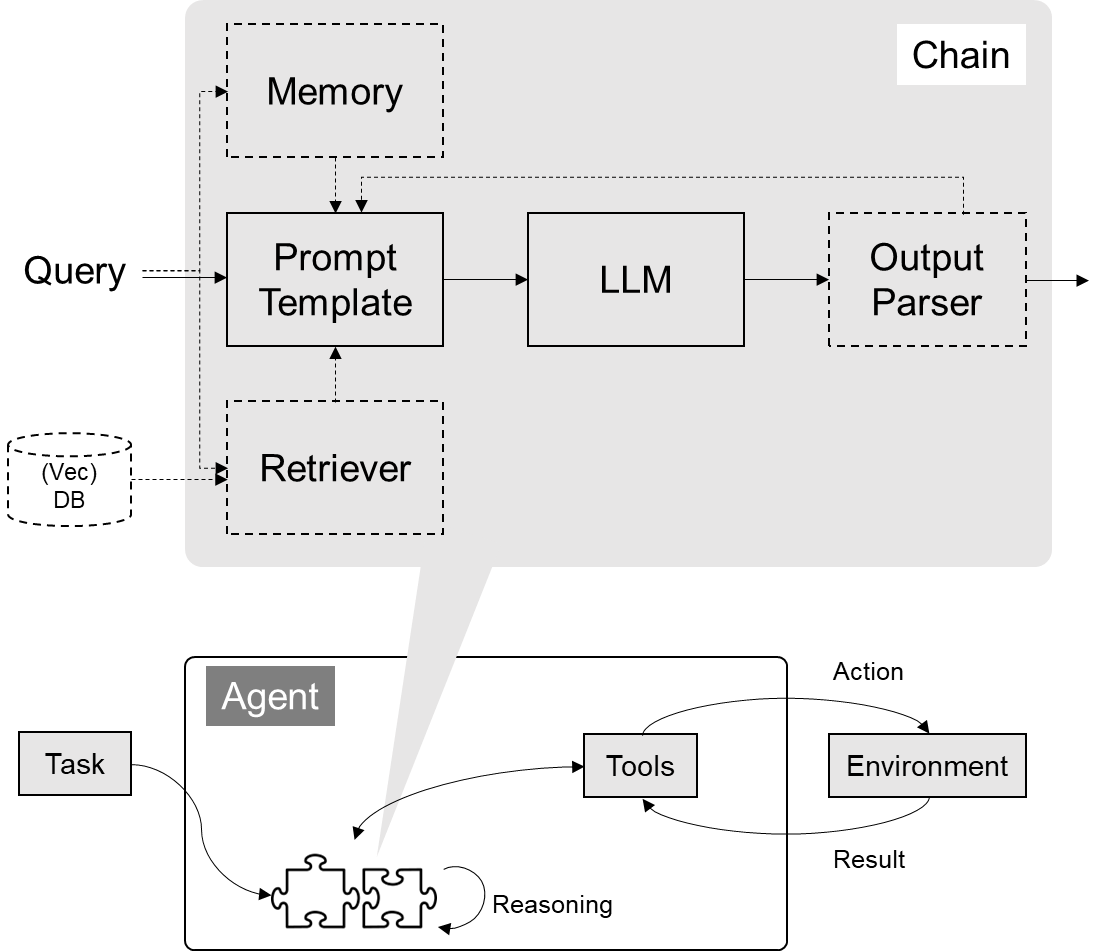

### 文档（以 Python 版为例）

- 功能模块：https://python.langchain.com/docs/get_started/introduction
- API 文档：https://api.python.langchain.com/en/latest/langchain_api_reference.html
- 三方组件集成：https://python.langchain.com/docs/integrations/platforms/
- 官方应用案例：https://python.langchain.com/docs/use_cases
- 调试部署等指导：https://python.langchain.com/docs/guides/debugging


## 一、模型 I/O 封装

把不同的模型，统一封装成一个接口，方便更换模型而不用重构代码。

### 1.1 模型 API：LLM vs. ChatModel


In [ ]:
# 安装最新版本
!pip install --upgrade langchain
!pip install --upgrade langchain-openai 

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_ENDPOINT"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = ""

OPENAI_API_KEY = "sk-xxxxx"

### 1.1.1 OpenAI 模型封装


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()  # 默认是gpt-3.5-turbo
response = llm.invoke("你是谁")
print(response.content)

我是一个人工智能助手，可以回答您的问题并提供帮助。有什么可以帮到您的吗？


### 1.1.2 多轮对话 Session 封装


In [3]:
from langchain.schema import (
    AIMessage,  # 等价于OpenAI接口中的assistant role
    HumanMessage,  # 等价于OpenAI接口中的user role
    SystemMessage  # 等价于OpenAI接口中的system role
)

messages = [
    SystemMessage(content="你是AGIClass的课程助理。"),
    HumanMessage(content="我是学员，我叫王卓然。"),
    AIMessage(content="欢迎！"),
    HumanMessage(content="我是谁")
]

ret = llm.invoke(messages)

print(ret.content)

你是王卓然。


<div class="alert alert-success">
<b>划重点：</b>通过模型封装，实现不同模型的统一接口调用
</div>


### 1.1.3 换个国产模型


In [ ]:
#!pip install qianfan

In [5]:
# 其它模型分装在 langchain_community 底包中
from langchain_community.chat_models import QianfanChatEndpoint
from langchain_core.messages import HumanMessage
import os

llm = QianfanChatEndpoint(
    qianfan_ak=os.getenv('ERNIE_CLIENT_ID'),
    qianfan_sk=os.getenv('ERNIE_CLIENT_SECRET')
)

messages = [
    HumanMessage(content="你是谁")
]

ret = llm.invoke(messages)

print(ret.content)

[INFO][2024-06-23 06:21:48.927] oauth.py:228 [t:139844412393280]: trying to refresh access_token for ak `cuTPS7***`
[INFO][2024-06-23 06:21:49.884] oauth.py:243 [t:139844412393280]: sucessfully refresh access_token


您好，我是百度研发的知识增强大语言模型，中文名是文心一言，英文名是ERNIE Bot。我能够与人对话互动，回答问题，协助创作，高效便捷地帮助人们获取信息、知识和灵感。


### 1.2 模型的输入与输出

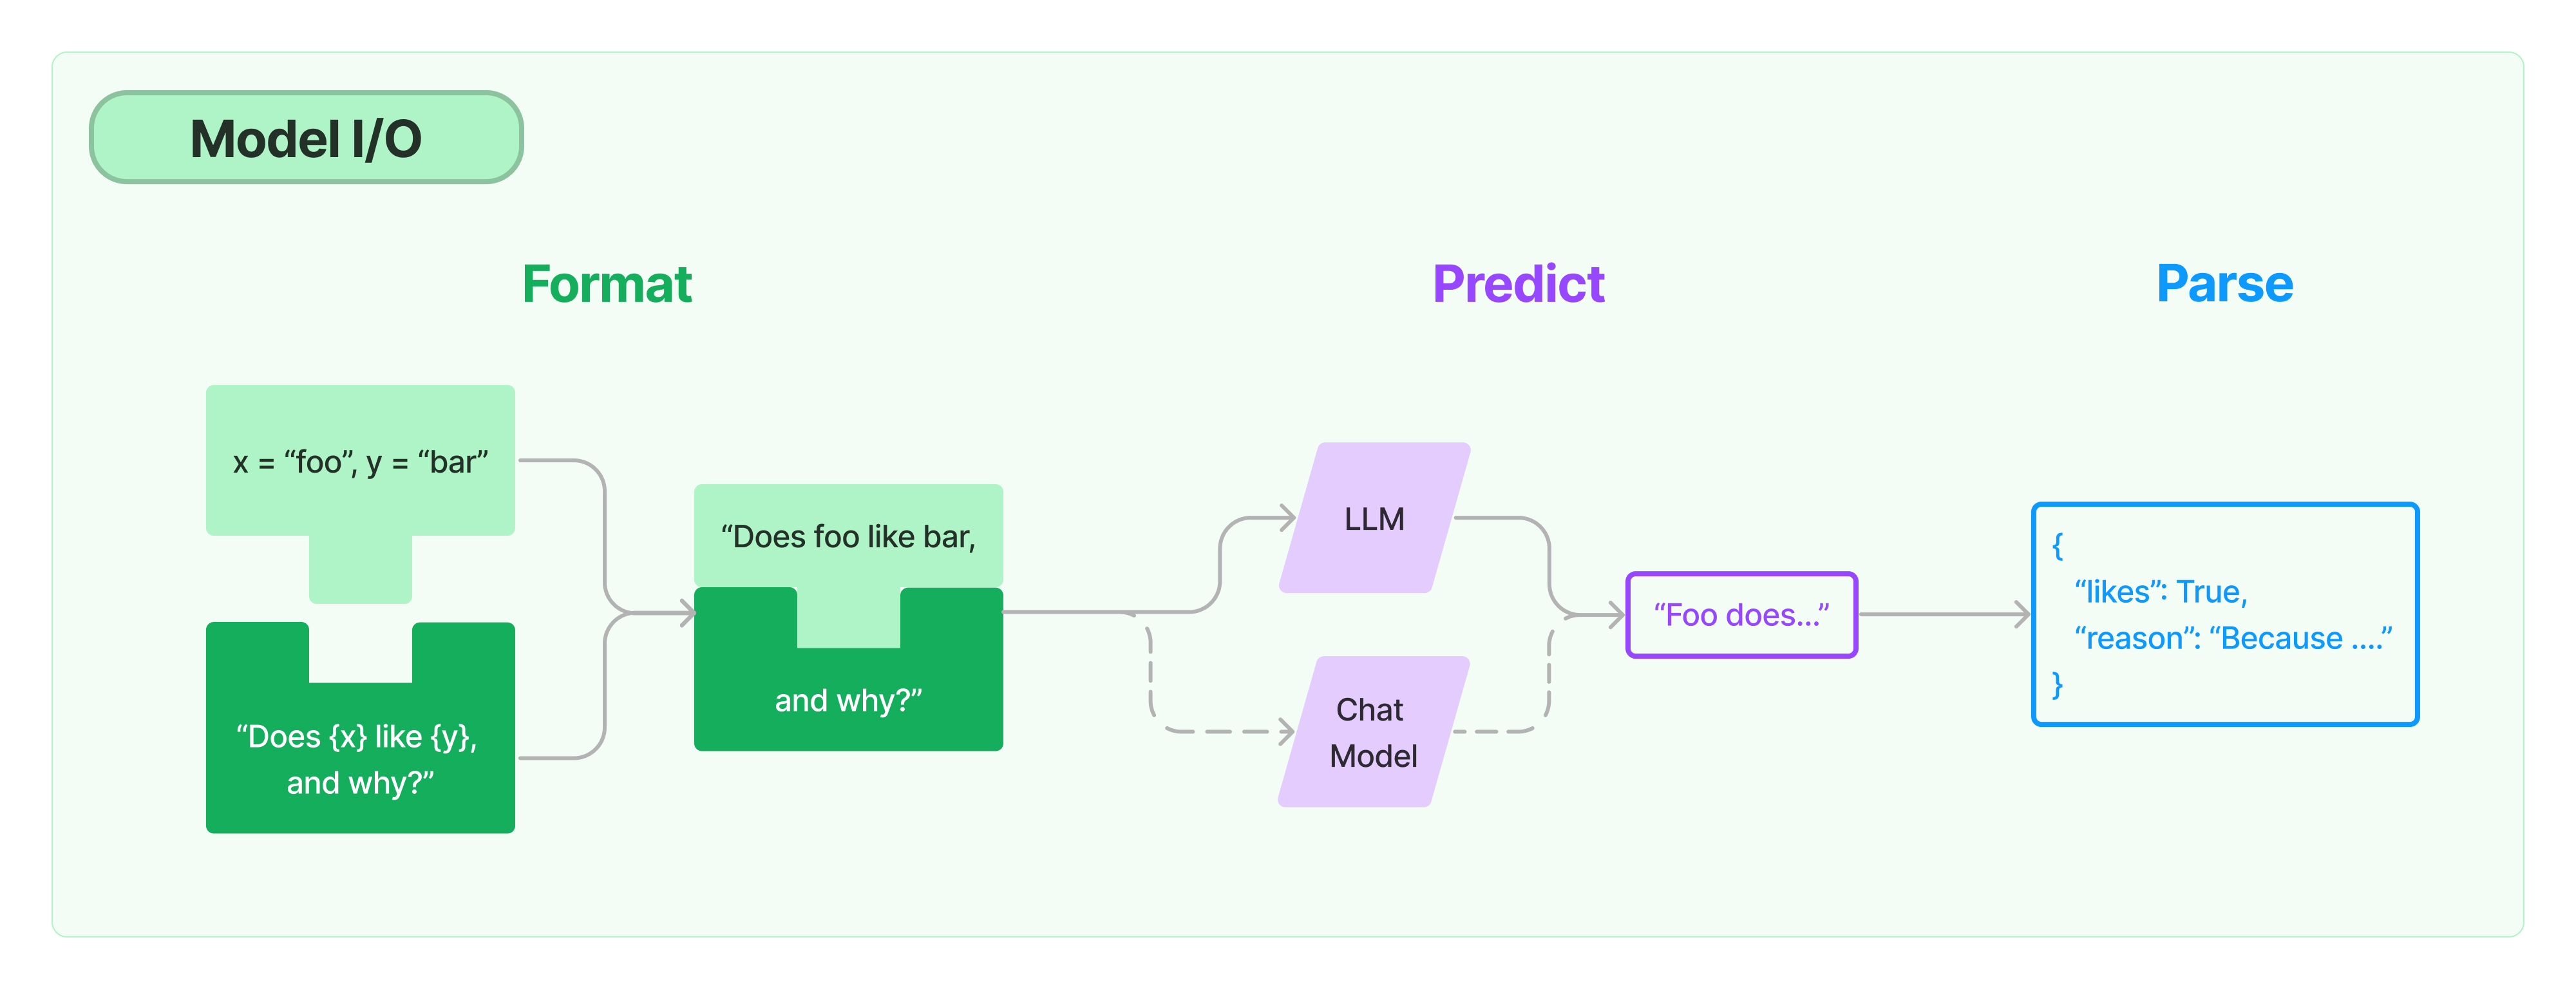
### 1.2.1 Prompt 模板封装

1. PromptTemplate 可以在模板中自定义变量


In [6]:
from langchain.prompts import PromptTemplate

template = PromptTemplate.from_template("给我讲个关于{subject}的笑话")
print("===Template===")
print(template)
print("===Prompt===")
print(template.format(subject='小明'))

===Template===
input_variables=['subject'] template='给我讲个关于{subject}的笑话'
===Prompt===
给我讲个关于小明的笑话


2. ChatPromptTemplate 用模板表示的对话上下文


In [7]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI

template = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            "你是{product}的客服助手。你的名字叫{name}"),
        HumanMessagePromptTemplate.from_template("{query}"),
    ]
)

llm = ChatOpenAI()
prompt = template.format_messages(
    product="AGI课堂",
    name="瓜瓜",
    query="你是谁"
)

ret = llm.invoke(prompt)

print(ret.content)

你好，我是AGI课堂的客服助手，叫瓜瓜。有什么问题我可以帮助你解答呢？


3. MessagesPlaceholder 把多轮对话变成模板


In [8]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

human_prompt = "Translate your answer to {language}."
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

chat_prompt = ChatPromptTemplate.from_messages(
    # variable_name 是 message placeholder 在模板中的变量名
    # 用于在赋值时使用
    [MessagesPlaceholder(variable_name="conversation"), human_message_template]
)

In [9]:
from langchain_core.messages import AIMessage, HumanMessage

human_message = HumanMessage(content="Who is Elon Musk?")
ai_message = AIMessage(
    content="Elon Musk is a billionaire entrepreneur, inventor, and industrial designer"
)

messages = chat_prompt.format_prompt(
    # 对 "conversation" 和 "language" 赋值
    conversation=[human_message, ai_message], language="中文"
)

print(messages.to_messages())

[HumanMessage(content='Who is Elon Musk?'), AIMessage(content='Elon Musk is a billionaire entrepreneur, inventor, and industrial designer'), HumanMessage(content='Translate your answer to 中文.')]


In [10]:
result = llm.invoke(messages)
print(result.content)

埃隆·马斯克是一位亿万富翁企业家、发明家和工业设计师。


<div class="alert alert-success">
<b>划重点：</b>把Prompt模板看作带有参数的函数，可类比于 SK 的 Semantic Function
</div>


### 1.2.2、从文件加载 Prompt 模板


In [11]:
from langchain.prompts import PromptTemplate

template = PromptTemplate.from_file("example_prompt_template.txt")
print("===Template===")
print(template)
print("===Prompt===")
print(template.format(topic='黑色幽默'))

===Template===
input_variables=['topic'] template='举一个关于{topic}的例子'
===Prompt===
举一个关于黑色幽默的例子


### 1.3 输出封装 OutputParser

自动把 LLM 输出的字符串按指定格式加载。

LangChain 内置的 OutputParser 包括:

- ListParser
- DatetimeParser
- EnumParser
- JsonOutputParser
- PydanticParser
- XMLParser

等等

### 1.3.1 Pydantic (JSON) Parser

自动根据 Pydantic 类的定义，生成输出的格式说明


In [12]:
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from typing import List, Dict

# 定义你的输出对象


class Date(BaseModel):
    year: int = Field(description="Year")
    month: int = Field(description="Month")
    day: int = Field(description="Day")
    era: str = Field(description="BC or AD")

    # ----- 可选机制 --------
    # 你可以添加自定义的校验机制
    @validator('month')
    def valid_month(cls, field):
        if field <= 0 or field > 12:
            raise ValueError("月份必须在1-12之间")
        return field

    @validator('day')
    def valid_day(cls, field):
        if field <= 0 or field > 31:
            raise ValueError("日期必须在1-31日之间")
        return field

    @validator('day', pre=True, always=True)
    def valid_date(cls, day, values):
        year = values.get('year')
        month = values.get('month')

        # 确保年份和月份都已经提供
        if year is None or month is None:
            return day  # 无法验证日期，因为没有年份和月份

        # 检查日期是否有效
        if month == 2:
            if cls.is_leap_year(year) and day > 29:
                raise ValueError("闰年2月最多有29天")
            elif not cls.is_leap_year(year) and day > 28:
                raise ValueError("非闰年2月最多有28天")
        elif month in [4, 6, 9, 11] and day > 30:
            raise ValueError(f"{month}月最多有30天")

        return day

    @staticmethod
    def is_leap_year(year):
        if year % 400 == 0 or (year % 4 == 0 and year % 100 != 0):
            return True
        return False

In [13]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_openai import ChatOpenAI

from langchain_core.output_parsers import PydanticOutputParser


model_name = 'gpt-3.5-turbo'
temperature = 0
model = ChatOpenAI(model_name=model_name, temperature=temperature)

# 根据Pydantic对象的定义，构造一个OutputParser
parser = PydanticOutputParser(pydantic_object=Date)

template = """提取用户输入中的日期。
{format_instructions}
用户输入:
{query}"""

prompt = PromptTemplate(
    template=template,
    input_variables=["query"],
    # 直接从OutputParser中获取输出描述，并对模板的变量预先赋值
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

print("====Format Instruction=====")
print(parser.get_format_instructions())


query = "2023年四月6日天气晴..."
model_input = prompt.format_prompt(query=query)

print("====Prompt=====")
print(model_input.to_string())

output = model.invoke(model_input.to_messages())
print("====模型原始输出=====")
print(output.content)
print("====Parse后的输出=====")
date = parser.parse(output.content)
print(date.dict())

====Format Instruction=====
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"year": {"title": "Year", "description": "Year", "type": "integer"}, "month": {"title": "Month", "description": "Month", "type": "integer"}, "day": {"title": "Day", "description": "Day", "type": "integer"}, "era": {"title": "Era", "description": "BC or AD", "type": "string"}}, "required": ["year", "month", "day", "era"]}
```
====Prompt=====
提取用户输入中的日期。
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"titl

### 1.3.2 Auto-Fixing Parser

利用 LLM 自动根据解析异常修复并重新解析


In [14]:
from langchain.output_parsers import OutputFixingParser

new_parser = OutputFixingParser.from_llm(
    parser=parser, llm=ChatOpenAI(model="gpt-3.5-turbo"))

# 我们把之前output的格式改错
output = output.content.replace("4", "四月")
print("===格式错误的Output===")
print(output)
try:
    date = parser.parse(output)
except Exception as e:
    print("===出现异常===")
    print(e)

# 用OutputFixingParser自动修复并解析
date = new_parser.parse(output)
print("===重新解析结果===")
print(date.json())

===格式错误的Output===
{
  "year": 2023,
  "month": 四月,
  "day": 6,
  "era": "AD"
}
===出现异常===
Invalid json output: {
  "year": 2023,
  "month": 四月,
  "day": 6,
  "era": "AD"
}
===重新解析结果===
{"year": 2023, "month": 4, "day": 6, "era": "AD"}


<div class="alert alert-warning">
<b>思考：</b>猜一下OutputFixingParser是怎么做到的
</div>


### 1.4、小结

1. LangChain 统一封装了各种模型的调用接口，包括补全型和对话型两种
2. LangChain 提供了 PromptTemplate 类，可以自定义带变量的模板
3. LangChain 提供了一些列输出解析器，用于将大模型的输出解析成结构化对象；额外带有自动修复功能。
4. 上述模型属于 LangChain 中较为优秀的部分；美中不足的是 OutputParser 自身的 Prompt 维护在代码中，耦合度较高。


## 二、数据连接封装

<img src="data_connection.jpg" style="margin-left: 0px" width=500px>

### 2.1 文档加载器：Document Loaders


In [66]:
#!pip install pypdf

In [15]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("llama2.pdf")
pages = loader.load_and_split()

print(pages[0].page_content)

Llama 2 : Open Foundation and Fine-Tuned Chat Models
Hugo Touvron∗Louis Martin†Kevin Stone†
Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra
Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen
Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller
Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou
Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev
Punit Singh Koura Marie-Anne Lachaux Thibaut Lavril Jenya Lee Diana Liskovich
Yinghai Lu Yuning Mao Xavier Martinet Todor Mihaylov Pushkar Mishra
Igor Molybog Yixin Nie Andrew Poulton Jeremy Reizenstein Rashi Rungta Kalyan Saladi
Alan Schelten Ruan Silva Eric Michael Smith Ranjan Subramanian Xiaoqing Ellen Tan Binh Tang
Ross Taylor Adina Williams Jian Xiang Kuan Puxin Xu Zheng Yan Iliyan Zarov Yuchen Zhang
Angela Fan Melanie Kambadur Sharan Narang Aurelien Rodriguez Robert Stojnic
Sergey Edunov 

### 2.2 文档处理器

### 2.2.1 TextSplitter


In [68]:
#!pip install --upgrade langchain-text-splitters

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=100, 
    length_function=len,
    add_start_index=True,
)

paragraphs = text_splitter.create_documents([pages[0].page_content])
for para in paragraphs:
    print(para.page_content)
    print('-------')

Llama 2 : Open Foundation and Fine-Tuned Chat Models
Hugo Touvron∗Louis Martin†Kevin Stone†
Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra
-------
Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra
Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen
-------
Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen
Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller
-------
Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller
Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou
-------
Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou
Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev
-------
Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev
Punit Singh Koura Marie-Anne Lachaux Thibaut Lavril 

<div class="alert alert-danger">
LangChain 的 PDFLoader 和 TextSplitter 实现都比较粗糙，实际生产中不建议使用。
</div>


### 2.3、向量数据库与向量检索


In [17]:
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader

# 加载文档
loader = PyPDFLoader("llama2.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=100,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:4]]
)

# 灌库
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
db = FAISS.from_documents(texts, embeddings)

# 检索 top-5 结果
retriever = db.as_retriever(search_kwargs={"k": 5})

docs = retriever.invoke("llama2有多少参数")

for doc in docs:
    print(doc.page_content)
    print("----")

but are not releasing.§
2.Llama 2-Chat , a ﬁne-tuned version of Llama 2 that is optimized for dialogue use cases. We release
variants of this model with 7B, 13B, and 70B parameters as well.
----
Abstract
In this work, we develop and release Llama 2, a collection of pretrained and ﬁne-tuned
large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters.
----
Llama 2-Chat , at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested,
----
large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters.
Our ﬁne-tuned LLMs, called Llama 2-Chat , are optimized for dialogue use cases. Our
----
adopted grouped-query attention (Ainslie et al., 2023). We are releasing variants of Llama 2 with
7B, 13B, and 70B parameters. We have also trained 34B variants, which we report on in this paper
----


更多的三方检索组件链接，参考：https://python.langchain.com/docs/integrations/vectorstores


### 2.4、小结

1. 文档处理部分 LangChain 实现较为粗糙，实际生产中不建议使用
2. 与向量数据库的链接部分本质是接口封装，向量数据库需要自己选型


## 三、记忆封装：Memory

### 3.1、对话上下文：ConversationBufferMemory


In [18]:
from langchain.memory import ConversationBufferMemory, ConversationBufferWindowMemory

history = ConversationBufferMemory()
history.save_context({"input": "你好啊"}, {"output": "你也好啊"})

print(history.load_memory_variables({}))

history.save_context({"input": "你再好啊"}, {"output": "你又好啊"})

print(history.load_memory_variables({}))

{'history': 'Human: 你好啊\nAI: 你也好啊'}
{'history': 'Human: 你好啊\nAI: 你也好啊\nHuman: 你再好啊\nAI: 你又好啊'}


### 3.2、只保留一个窗口的上下文：ConversationBufferWindowMemory


In [19]:
from langchain.memory import ConversationBufferWindowMemory

window = ConversationBufferWindowMemory(k=2)
window.save_context({"input": "第一轮问"}, {"output": "第一轮答"})
window.save_context({"input": "第二轮问"}, {"output": "第二轮答"})
window.save_context({"input": "第三轮问"}, {"output": "第三轮答"})
print(window.load_memory_variables({}))

{'history': 'Human: 第二轮问\nAI: 第二轮答\nHuman: 第三轮问\nAI: 第三轮答'}


### 3.3、通过 Token 数控制上下文长度：ConversationTokenBufferMemory


In [20]:
from langchain.memory import ConversationTokenBufferMemory
from langchain_openai import ChatOpenAI

memory = ConversationTokenBufferMemory(
    llm=ChatOpenAI(),
    max_token_limit=40
)
memory.save_context(
    {"input": "你好啊"}, {"output": "你好，我是你的AI助手。"})
memory.save_context(
    {"input": "你会干什么"}, {"output": "我什么都会"})

print(memory.load_memory_variables({}))

{'history': 'AI: 你好，我是你的AI助手。\nHuman: 你会干什么\nAI: 我什么都会'}


### 3.4、更多类型

- ConversationSummaryMemory: 对上下文做摘要
  - https://python.langchain.com/docs/modules/memory/types/summary
- ConversationSummaryBufferMemory: 保存 Token 数限制内的上下文，对更早的做摘要
  - https://python.langchain.com/docs/modules/memory/types/summary_buffer
- VectorStoreRetrieverMemory: 将 Memory 存储在向量数据库中，根据用户输入检索回最相关的部分
  - https://python.langchain.com/docs/modules/memory/types/vectorstore_retriever_memory


### 3.5、小结

1. LangChain 的 Memory 管理机制属于可用的部分，尤其是简单情况如按轮数或按 Token 数管理；
2. 对于复杂情况，它不一定是最优的实现，例如检索向量库方式，建议根据实际情况和效果评估；
3. 但是**它对内存的各种维护方法的思路在实际生产中可以借鉴**。


## 四、Chain 和 LangChain Expression Language (LCEL)


LangChain Expression Language（LCEL）是一种声明式语言，可轻松组合不同的调用顺序构成 Chain。LCEL 自创立之初就被设计为能够支持将原型投入生产环境，**无需代码更改**，从最简单的“提示+LLM”链到最复杂的链（已有用户成功在生产环境中运行包含数百个步骤的 LCEL Chain）。

LCEL 的一些亮点包括：

1. **流支持**：使用 LCEL 构建 Chain 时，你可以获得最佳的首个令牌时间（即从输出开始到首批输出生成的时间）。对于某些 Chain，这意味着可以直接从 LLM 流式传输令牌到流输出解析器，从而以与 LLM 提供商输出原始令牌相同的速率获得解析后的、增量的输出。

2. **异步支持**：任何使用 LCEL 构建的链条都可以通过同步 API（例如，在 Jupyter 笔记本中进行原型设计时）和异步 API（例如，在 LangServe 服务器中）调用。这使得相同的代码可用于原型设计和生产环境，具有出色的性能，并能够在同一服务器中处理多个并发请求。

3. **优化的并行执行**：当你的 LCEL 链条有可以并行执行的步骤时（例如，从多个检索器中获取文档），我们会自动执行，无论是在同步还是异步接口中，以实现最小的延迟。

4. **重试和回退**：为 LCEL 链的任何部分配置重试和回退。这是使链在规模上更可靠的绝佳方式。目前我们正在添加重试/回退的流媒体支持，因此你可以在不增加任何延迟成本的情况下获得增加的可靠性。

5. **访问中间结果**：对于更复杂的链条，访问在最终输出产生之前的中间步骤的结果通常非常有用。这可以用于让最终用户知道正在发生一些事情，甚至仅用于调试链条。你可以流式传输中间结果，并且在每个 LangServe 服务器上都可用。

6. **输入和输出模式**：输入和输出模式为每个 LCEL 链提供了从链的结构推断出的 Pydantic 和 JSONSchema 模式。这可以用于输入和输出的验证，是 LangServe 的一个组成部分。

7. **无缝 LangSmith 跟踪集成**：随着链条变得越来越复杂，理解每一步发生了什么变得越来越重要。通过 LCEL，所有步骤都自动记录到 LangSmith，以实现最大的可观察性和可调试性。

8. **无缝 LangServe 部署集成**：任何使用 LCEL 创建的链都可以轻松地使用 LangServe 进行部署。

原文：https://python.langchain.com/docs/expression_language/


### 4.1 Pipeline 式调用 PromptTemplate, LLM 和 OutputParser


In [21]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from typing import List, Dict, Optional
from enum import Enum
import json

In [23]:
# 输出结构
class SortEnum(str, Enum):
    data = 'data'
    price = 'price'


class OrderingEnum(str, Enum):
    ascend = 'ascend'
    descend = 'descend'


class Semantics(BaseModel):
    name: Optional[str] = Field(description="流量包名称", default=None)
    price_lower: Optional[int] = Field(description="价格下限", default=None)
    price_upper: Optional[int] = Field(description="价格上限", default=None)
    data_lower: Optional[int] = Field(description="流量下限", default=None)
    data_upper: Optional[int] = Field(description="流量上限", default=None)
    sort_by: Optional[SortEnum] = Field(description="按价格或流量排序", default=None)
    ordering: Optional[OrderingEnum] = Field(
        description="升序或降序排列", default=None)


# OutputParser
parser = PydanticOutputParser(pydantic_object=Semantics)

# Prompt 模板
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "将用户的输入解析成JSON表示。输出格式如下：\n{format_instructions}\n不要输出未提及的字段。",
        ),
        ("human", "{text}"),
    ]
).partial(format_instructions=parser.get_format_instructions())

# 模型
model = ChatOpenAI(model="gpt-4-turbo", temperature=0)

# LCEL 表达式
runnable = (
    {"text": RunnablePassthrough()} | prompt | model | StrOutputParser()
)

# 运行
# for s in runnable.stream("不超过100元的流量大的套餐有哪些"):
#    print(s, end="")
print(json.dumps(ret.dict(),indent=4,ensure_ascii=False))

{
    "content": "你好，我是AGI课堂的客服助手，叫瓜瓜。有什么问题我可以帮助你解答呢？",
    "additional_kwargs": {},
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 45,
            "prompt_tokens": 42,
            "total_tokens": 87
        },
        "model_name": "gpt-3.5-turbo-0125",
        "system_fingerprint": null,
        "finish_reason": "stop",
        "logprobs": null
    },
    "type": "ai",
    "name": null,
    "id": "run-6fdbef8c-0082-44a7-a79f-4aa5a5ad52bc-0",
    "example": false,
    "tool_calls": [],
    "invalid_tool_calls": [],
    "usage_metadata": {
        "input_tokens": 42,
        "output_tokens": 45,
        "total_tokens": 87
    }
}


<div class="alert alert-warning">
<b>注意:</b> 在当前的文档中 LCEL 产生的对象，被叫做 runnable 或 chain，经常两种叫法混用。本质就是一个自定义调用流程。
</div>


<div class="alert alert-success">
<b>使用 LCEL 的价值，也就是 LangChain 的核心价值。</b> <br />
官方从不同角度给出了举例说明：https://python.langchain.com/docs/expression_language/why
</div>


### 4.2 用 LCEL 实现 RAG


In [24]:
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain_community.document_loaders import PyPDFLoader

# 加载文档
loader = PyPDFLoader("llama2.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=100,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:4]]
)

# 灌库
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
db = FAISS.from_documents(texts, embeddings)

# 检索 top-1 结果
retriever = db.as_retriever(search_kwargs={"k": 5})

In [25]:
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

# Prompt模板
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Chain
rag_chain = (
    {"question": RunnablePassthrough(), "context": retriever}
    | prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("Llama 2有多少参数")

'Llama 2的参数范围从7亿到70亿不等。'

### 4.3 通过 LCEL 实现 Function Calling


In [26]:
from langchain_core.tools import tool


@tool
def multiply(first_int: int, second_int: int) -> int:
    """两个整数相乘"""
    return first_int * second_int


@tool
def add(first_int: int, second_int: int) -> int:
    """Add two integers."""
    return first_int + second_int


@tool
def exponentiate(base: int, exponent: int) -> int:
    """Exponentiate the base to the exponent power."""
    return base**exponent

In [27]:
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import JsonOutputToolsParser

tools = [multiply, add, exponentiate]
# 带有分支的 LCEL
llm_with_tools = model.bind_tools(tools) | {
    "functions": JsonOutputToolsParser(),
    "text": StrOutputParser()
}

In [28]:
result = llm_with_tools.invoke("1024的16倍是多少")

print(result)

{'functions': [{'args': {'first_int': 1024, 'second_int': 16}, 'type': 'multiply'}], 'text': ''}


In [29]:
result = llm_with_tools.invoke("你是谁")

print(result)

{'functions': [], 'text': '您好！我是一个人工智能助手，可以帮助您解答问题、提供信息、执行计算等多种服务。有什么我可以帮您的吗？'}


#### 直接选择工具并运行（选）


In [30]:
from typing import Union
from operator import itemgetter
from langchain_core.runnables import (
    Runnable,
    RunnableLambda,
    RunnableMap,
    RunnablePassthrough,
)

# 名称到函数的映射
tool_map = {tool.name: tool for tool in tools}


def call_tool(tool_invocation: dict) -> Union[str, Runnable]:
    """根据模型选择的 tool 动态创建 LCEL"""
    tool = tool_map[tool_invocation["type"]]
    return RunnablePassthrough.assign(
        output=itemgetter("args") | tool
    )


# .map() 使 function 逐一作用与一组输入
call_tool_list = RunnableLambda(call_tool).map()

In [31]:
import json


def route(response):
    if len(response["functions"]) > 0:
        return response["functions"]
    else:
        return response["text"]


llm_with_tools = model.bind_tools(tools) | {
    "functions": JsonOutputToolsParser() | call_tool_list,
    "text": StrOutputParser()
} | RunnableLambda(route)

result = llm_with_tools.invoke("1024的平方是多少")
print(result)

result = llm_with_tools.invoke("你好")
print(result)

[{'args': {'base': 1024, 'exponent': 2}, 'type': 'exponentiate', 'output': 1048576}]
你好！有什么我可以帮助你的吗？


<div class="alert alert-warning">
这种写法可读性太差了，个人不建议使用过于复杂的 LCEL！
</div>


### 4.4 用 LCEL 实现工厂模式（选）

In [32]:
from langchain_core.runnables.utils import ConfigurableField
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import QianfanChatEndpoint
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import HumanMessage
import os

# 模型1
ernie_model = QianfanChatEndpoint(
    qianfan_ak=os.getenv('ERNIE_CLIENT_ID'),
    qianfan_sk=os.getenv('ERNIE_CLIENT_SECRET')
)

# 模型2
gpt_model = ChatOpenAI()


# 通过 configurable_alternatives 按指定字段选择模型
model = gpt_model.configurable_alternatives(
    ConfigurableField(id="llm"), 
    default_key="gpt", 
    ernie=ernie_model,
    # claude=claude_model,
)

# Prompt 模板
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template("{query}"),
    ]
)

# LCEL
chain = (
    {"query": RunnablePassthrough()} 
    | prompt
    | model 
    | StrOutputParser()
)

# 运行时指定模型 "gpt" or "ernie"
ret = chain.with_config(configurable={"llm": "ernie"}).invoke("介绍你自己，包括你的生产商")

print(ret)

我是由百度公司开发的人工智能产品，我的中文名是文心一言。我的英文名是ERNIE Bot，我能够与人对话互动，回答问题，协助创作，高效便捷地帮助人们获取信息、知识和灵感。

如果您有任何问题或需要帮助，欢迎随时向我提问，我会尽力提供准确有用的信息。


扩展阅读：什么是[**工厂模式**](https://www.runoob.com/design-pattern/factory-pattern.html)；[**设计模式**](https://www.runoob.com/design-pattern/design-pattern-intro.html)概览。

<div class="alert alert-warning">
<b>思考：</b>从模块间解依赖角度，LCEL的意义是什么？
</div>


### 通过 LCEL，还可以实现

1. 配置运行时变量：https://python.langchain.com/docs/expression_language/how_to/configure
2. 故障回退：https://python.langchain.com/docs/expression_language/how_to/fallbacks
3. 并行调用：https://python.langchain.com/docs/expression_language/how_to/map
4. 逻辑分支：https://python.langchain.com/docs/expression_language/how_to/routing
5. 调用自定义流式函数：https://python.langchain.com/docs/expression_language/how_to/generators
6. 链接外部 Memory：https://python.langchain.com/docs/expression_language/how_to/message_history

更多例子：https://python.langchain.com/docs/expression_language/cookbook/


## 五、智能体架构：Agent


### 5.1 回忆：什么是智能体（Agent）

将大语言模型作为一个推理引擎。给定一个任务，智能体自动生成完成任务所需的步骤，执行相应动作（例如选择并调用工具），直到任务完成。

<img src="agent-overview.png" style="margin-left: 0px" width=500px>


### 5.2 先定义一些工具：Tools

- 可以是一个函数或三方 API
- 也可以把一个 Chain 或者 Agent 的 run()作为一个 Tool


In [33]:
from langchain_community.utilities import SerpAPIWrapper
from langchain.tools import Tool, tool

search = SerpAPIWrapper()
tools = [
    Tool.from_function(
        func=search.run,
        name="Search",
        description="useful for when you need to answer questions about current events"
    ),
]

需要注册 [SerpAPI](https://serpapi.com/)（限量免费），并将 `SERPAPI_API_KEY` 写在环境变量中

In [34]:
import calendar
import dateutil.parser as parser
from datetime import date

# 自定义工具


@tool("weekday")
def weekday(date_str: str) -> str:
    """Convert date to weekday name"""
    d = parser.parse(date_str)
    return calendar.day_name[d.weekday()]


tools += [weekday]

### 5.3 智能体类型：ReAct


<img src="ReAct.png" style="margin-left: 0px" width=500px>


In [ ]:
!pip install google-search-results

In [ ]:
!pip install --upgrade langchainhub

In [38]:
from langchain import hub
import json

# 下载一个现有的 Prompt 模板
prompt = hub.pull("hwchase17/react")

print(prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [39]:
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent


llm = ChatOpenAI(model_name='gpt-4o', temperature=0)

# 定义一个 agent: 需要大模型、工具集、和 Prompt 模板
agent = create_react_agent(llm, tools, prompt)
# 定义一个执行器：需要 agent 对象 和 工具集
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# 执行
agent_executor.invoke({"input": "2024年周杰伦的演唱会星期几"})



> Entering new AgentExecutor chain...
The question is asking for the day of the week for Jay Chou's concert in 2024. To answer this, I need to find the specific date of the concert first and then determine the day of the week for that date.

Action: Search
Action Input: 2024 Jay Chou concert dateUPDATED: May 10, 2024 Taiwanese music superstar Jay Chou (pic) will be back in Malaysia and Singapore later in 2024. He is slated to play three concerts from Oct 11 to 13 at the National Stadium in Singapore and will hold one show at Bukit Jalil National Stadium in Kuala Lumpur on Oct 26.The search result indicates that Jay Chou will have concerts on October 11, 12, 13, and 26 in 2024. I need to determine the days of the week for these dates.

Action: weekday
Action Input: 2024-10-11FridayThe concert on October 11, 2024, is on a Friday. I need to determine the days of the week for the other dates as well.

Action: weekday
Action Input: 2024-10-12SaturdayThe concert on October 12, 2024, is on 

{'input': '2024年周杰伦的演唱会星期几',
 'output': "Jay Chou's concerts in 2024 are on the following days of the week:\n- October 11, 2024: Friday\n- October 12, 2024: Saturday\n- October 13, 2024: Sunday\n- October 26, 2024: Saturday"}

### 5.4 智能体类型：SelfAskWithSearch


In [40]:
# 下载一个模板
prompt = hub.pull("hwchase17/self-ask-with-search")

print(prompt.template)

Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washin

In [41]:
from langchain.agents import create_self_ask_with_search_agent

tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description="useful for when you need to ask with search.",
    )
]

# self_ask_with_search_agent 只能传一个名为 'Intermediate Answer' 的 tool
agent = create_self_ask_with_search_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

agent_executor.invoke({"input": "冯小刚的老婆演过哪些电影"})



> Entering new AgentExecutor chain...
Yes.

Follow up: Who is 冯小刚's (Feng Xiaogang's) wife?['Feng Xiaogang is a Chinese film director, screenwriter, actor, producer and politician. He is well known in China as a highly successful commercial ...', 'Feng Xiaogang and his wife Xu Fan. 《大腕》 "Big Shot\'s Funeral" (2001) [writer/director]. 《谁说我不在乎》 "The Marriage ...', "Son Ye Jin was cast for directors Kang Je Gyu and Feng Xiaogang (冯小刚)'s new film. 'Bad Guys Always Die ... Mark Zuckerberg and Wife Priscilla ...", 'The film stars Fan Bingbing, Zhang Jiayi, Yu Hewei, Dong Chengpeng and Guo Tao. It was selected to be screened in the Special Presentations section at the 2016 ...', '... wife and live with his lover. But the man regrets his plan at the last moment ... Feng, Xiaogang 馮小剛. Wo ba qingchun xiangei ni 我把青春獻給你 [I Gave My ...', "Two of the most highly anticipated Chinese films, Director Feng Xiaogang's (馮小剛) ... Daniel shouts out his love for his wife, Lisa S. By kiki April 16, 2024 ·

{'input': '冯小刚的老婆演过哪些电影',
 'output': 'Xu Fan has acted in movies such as "Aftershock," "Cell Phone," "The Dream Factory," and "If You Are the One."'}

<div class="alert alert-success">
<b>划重点：</b>
<ol>
<li>ReAct 是比较常用的 Planner</li>
<li>SelfAskWithSearch 更适合需要层层推理的场景（例如知识图谱）</li>
<li>Agent落地应用需要更多细节，后面课程中我们会专门讲 Agent 的实现</li>
</ol>
</div>


## 六、LangServe

LangServe 用于将 Chain 或者 Runnable 部署成一个 REST API 服务。


In [ ]:
# 安装 LangServe
# !pip install --upgrade "langserve[all]"

# 也可以只安装一端
# !pip install "langserve[client]"
# !pip install "langserve[server]"

### 6.1、Server 端


```python
#!/usr/bin/env python
from fastapi import FastAPI
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langserve import add_routes
import uvicorn

app = FastAPI(
  title="LangChain Server",
  version="1.0",
  description="A simple api server using Langchain's Runnable interfaces",
)

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("讲一个关于{topic}的笑话")
add_routes(
    app,
    prompt | model,
    path="/joke",
)

if __name__ == "__main__":
    uvicorn.run(app, host="localhost", port=9999)
```


### 6.2、Client 端


```python
import requests

response = requests.post(
    "http://localhost:9999/joke/invoke",
    json={'input': {'topic': '小明'}}
)
print(response.json())
```


## 七、LangChain.js

Python 版 LangChain 的姊妹项目，都是由 Harrison Chase 主理。

项目地址：https://github.com/langchain-ai/langchainjs

文档地址：https://js.langchain.com/docs/

特色：

1. 可以和 Python 版 LangChain 无缝对接

2. 抽象设计完全相同，概念一一对应

3. 所有对象序列化后都能跨语言使用，但 API 差别挺大，不过在努力对齐

支持环境：

1. Node.js (ESM and CommonJS) - 18.x, 19.x, 20.x
2. Cloudflare Workers
3. Vercel / Next.js (Browser, Serverless and Edge functions)
4. Supabase Edge Functions
5. Browser
6. Deno

安装：

```
npm install langchain
```

当前重点：

1. 追上 Python 版的能力（甚至为此做了一个基于 gpt-3.5-turbo 的代码翻译器）
2. 保持兼容尽可能多的环境
3. 对质量关注不多，随时间自然能解决


### LangChain 与 LlamaIndex 的错位竞争

- LangChain 侧重与 LLM 本身交互的封装
  - Prompt、LLM、Memory、OutputParser 等工具丰富
  - 在数据处理和 RAG 方面提供的工具相对粗糙
  - 主打 LCEL 流程封装
  - 配套 Agent、LangGraph 等智能体与工作流工具
  - 另有 LangServe 部署工具和 LangSmith 监控调试工具
- LlamaIndex 侧重与数据交互的封装
  - 数据加载、切割、索引、检索、排序等相关工具丰富
  - Prompt、LLM 等底层封装相对单薄
  - 配套实现 RAG 相关工具
  - 有 Agent 相关工具，不突出
- LlamaIndex 为 LangChain 提供了集成
  - 在 LlamaIndex 中调用 LangChain 封装的 LLM 接口：https://docs.llamaindex.ai/en/stable/api_reference/llms/langchain/
  - 将 LlamaIndex 的 Query Engine 作为 LangChain Agent 的工具：https://docs.llamaindex.ai/en/v0.10.17/community/integrations/using_with_langchain.html
  - LangChain 也 *曾经* 集成过 LlamaIndex，目前相关接口仍在：https://api.python.langchain.com/en/latest/retrievers/langchain_community.retrievers.llama_index.LlamaIndexRetriever.html

## 总结

1. LangChain 随着版本迭代可用性有明显提升
2. 使用 LangChain 要注意维护自己的 Prompt，尽量 Prompt 与代码逻辑解依赖
3. 它的内置基础工具，建议充分测试效果后再决定是否使用


## 作业


用 LangChain 重构 ChatPDF 的作业
